In [20]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

Read the data and save it in a data frame type.

In [21]:
match_away_team_df=pd.read_csv('MatchAwayTeamInfo.csv')
match_home_team_df=pd.read_csv('MatchHomeTeamInfo.csv')
event_df = pd.read_csv('MatchEventInfo.csv')
match_time_df=pd.read_csv('MatchTimeInfo.csv')
period_df=pd.read_csv('PeriodInfo.csv')
tournament_df=pd.read_csv('MatchTournamentInfo.csv')

Remove missing values from data using forward fill strategy.

1- Get the number of players from the MatchHomeTeamInfo(df) and MatchAwayTeamInfo(df1).

In [22]:
all_player_ids = pd.concat([match_away_team_df['player_id'], match_home_team_df['player_id']])
num_players = len(all_player_ids.unique())
print("Total number of players:",num_players)


Total number of players: 2039


2. What is the average height of the players?

In [23]:

height_player_mean=pd.concat([match_away_team_df['height'],match_home_team_df['height']]).mean()
print("Average height of players:",height_player_mean)

Average height of players: 1.8189373183893733


According to the given information, the average height of the players in this series of matches is 1.82

3. Which player has the highest number of wins?

In [24]:
event_df.dropna(inplace=True)
winner_df=event_df[['match_id','winner_code']]
winner_df

,match_id,winner_code
1,12260076,1.0
2,12260077,2.0
3,12260078,1.0
4,12260080,1.0
5,12260081,1.0
...,...,...
20278,12346486,2.0
20288,12360758,1.0
20289,12360760,2.0
20295,12361503,1.0


In [25]:
merged_player= pd.merge(match_away_team_df, match_home_team_df, on='match_id',how='inner', suffixes=('_player1', '_player2'))
merged_player =merged_player [['match_id','name_player1', 'name_player2']]
merged_player

,match_id,name_player1,name_player2
0,12260075,Lehečka J.,Lehečka J.
1,12260076,Khachanov K.,Khachanov K.
2,12260077,Alcaraz C.,Alcaraz C.
3,12260078,Alcaraz C.,Alcaraz C.
4,12260078,Alcaraz C.,Alcaraz C.
...,...,...,...
31141,12384975,Șerban R.,Șerban R.
31142,12385017,Pedretti T.,Pedretti T.
31143,12385869,Fukuda S.,Fukuda S.
31144,12385873,Uchida K.,Uchida K.


In [26]:
playerWinner = pd.merge(merged_player , winner_df, on='match_id', how='inner')
playerWinner['winner_name'] = playerWinner.apply(lambda row: row['name_player1'] if row['winner_code'] == 1.0 else row['name_player2'], axis=1)

# Determine which player wins the most matches
winner_counts = playerWinner['winner_name'].value_counts()
print("The player who wins the most matches is:", winner_counts.idxmax())


The player who wins the most matches is: Monteiro T.


4. What is the longest match recorded in terms of duration?

In [27]:
match_time_df.fillna(0,inplace=True)
match_time_df.drop_duplicates(inplace=True)

In [28]:

match_time_df['sumation_time_periods_match']=match_time_df.iloc[:,[1,2,3,4,5]].sum(axis=1)
match_time_df.head()

,match_id,period_1,period_2,period_3,period_4,period_5,current_period_start_timestamp,sumation_time_periods_match
0,12260075,3463.0,3855.0,0.0,0.0,0.0,1.714511e+09,7318.0
1,12260076,3032.0,2121.0,2674.0,0.0,0.0,1.714492e+09,7827.0
2,12260077,2747.0,3525.0,4074.0,0.0,0.0,1.714492e+09,10346.0
3,12260078,2519.0,2531.0,2121.0,0.0,0.0,1.714578e+09,7171.0
4,12260080,2616.0,2766.0,0.0,0.0,0.0,1.714483e+09,5382.0


In [29]:
longest_time=match_time_df['sumation_time_periods_match'].max()
longest_match=match_time_df.loc[(match_time_df['sumation_time_periods_match']==longest_time),:]
longest_match

,match_id,period_1,period_2,period_3,period_4,period_5,current_period_start_timestamp,sumation_time_periods_match
13350,12346747,167761.0,3392.0,0.0,0.0,0.0,1.716382e+09,171153.0


According to the given information ,the longest match recorded in terms of duration is the match with match-id:12346747 with 171153ps or 16h

5. How many sets are typically played in a tennis match?

In [30]:
power_df = pd.read_csv('PowerInfo.csv')
power_df.head()
num_sets_per_match = power_df.groupby('match_id')['set_num'].nunique()
print(num_sets_per_match)

match_id
12260075    2
12260076    3
12260077    3
12260078    3
12260080    2
           ..
12384789    2
12384806    3
12384892    2
12384975    3
12385017    3
Name: set_num, Length: 6658, dtype: int64


6. Which country has produced the most successful tennis players?

In [31]:
merged_player_id = pd.merge(match_away_team_df, match_home_team_df, on='match_id',how='inner', suffixes=('_player1', '_player2'))
merged_match_id_name_country=merged_player_id[['match_id','name_player1', 'name_player2','country_player1','country_player2']]

playerWinner = pd.merge(merged_match_id_name_country, winner_df, on='match_id', how='inner')

playerWinner['winner_name'] = playerWinner.apply(lambda row: row['name_player1'] if row['winner_code'] == 1.0 else row['name_player2'], axis=1)
playerWinner['winner_country'] = playerWinner.apply(lambda row: row['country_player1'] if row['winner_code'] == 1.0 else row['country_player2'], axis=1)

winner_country = playerWinner['winner_country'].value_counts()
print("The player who wins the most matches is:", winner_country.idxmax())

playerWinner

The player who wins the most matches is: France


,match_id,name_player1,name_player2,country_player1,country_player2,winner_code,winner_name,winner_country
0,12260076,Khachanov K.,Khachanov K.,Russia,Russia,1.0,Khachanov K.,Russia
1,12260077,Alcaraz C.,Alcaraz C.,Spain,Spain,2.0,Alcaraz C.,Spain
2,12260078,Alcaraz C.,Alcaraz C.,Spain,Spain,1.0,Alcaraz C.,Spain
3,12260078,Alcaraz C.,Alcaraz C.,Spain,Spain,1.0,Alcaraz C.,Spain
4,12260078,Alcaraz C.,Alcaraz C.,Spain,Spain,1.0,Alcaraz C.,Spain
...,...,...,...,...,...,...,...,...
8137,12361506,Cecchinato M.,Cecchinato M.,Italy,Italy,1.0,Cecchinato M.,Italy
8138,12361506,Cecchinato M.,Cecchinato M.,Italy,Italy,1.0,Cecchinato M.,Italy
8139,12361506,Cecchinato M.,Cecchinato M.,Italy,Italy,1.0,Cecchinato M.,Italy
8140,12361506,Cecchinato M.,Cecchinato M.,Italy,Italy,1.0,Cecchinato M.,Italy


7. What is the average number of aces per match?

In [32]:

aces_stats = period_df[period_df['statistic_name'] == 'aces']
total_aces = aces_stats['home_value'].sum() + aces_stats['away_value'].sum()

# Count the number of matches
num_matches = event_df['match_id'].nunique()

# Calculate the average number of aces per match
average_aces_per_match = total_aces / num_matches

print(f"The average number of aces per match is {average_aces_per_match:.2f}.")

The average number of aces per match is 102.69.


8. Is there a difference in the number of double faults based on gender?

<Figure size 800x600 with 0 Axes>

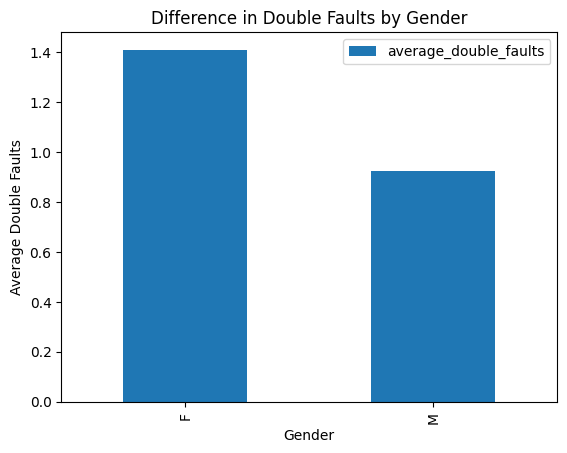

,gender,home_value,away_value,average_double_faults
0,F,1.392041,1.426807,1.409424
1,M,0.917197,0.927433,0.922315


In [33]:
players_id_concat = pd.concat([match_away_team_df, match_home_team_df])
period_df.fillna(0)

player_period_merged = pd.merge(players_id_concat, period_df, on='match_id')
player_period_merged
# double_faults filter
double_faults_stats = player_period_merged[player_period_merged['statistic_name'] == 'double_faults']

# average double faults for each gender
gender_double_faults = double_faults_stats.groupby('gender')[['home_value', 'away_value']].mean().reset_index()
# total average
gender_double_faults['average_double_faults'] = (gender_double_faults['home_value'] + gender_double_faults['away_value']) / 2

# plot the results
plt.figure(figsize=(8, 6))
gender_double_faults.plot( x='gender', y='average_double_faults' ,kind='bar')

plt.xlabel('Gender')
plt.ylabel('Average Double Faults')
plt.title('Difference in Double Faults by Gender')
plt.show()

gender_double_faults


In conclusion of the given information, there is a difference between male and female in the number of double faults. The average double faults value is more in females than in males.

9. Which player has won the most tournaments in a single month?
We use the playerWinner dataframe previousely produced in question 3. It contains 'match_id', 'name_player1', 'name_player2' and 'winner_name' fields. Now we join this dataframe with the MatchTournamentInfo dataframe to get the player that won the most tournaments.

In [34]:

playerWinnerTourn = pd.merge(playerWinner, tournament_df, on='match_id', how='inner')
playerWinnerTourn=playerWinnerTourn[['match_id','name_player1','name_player2','tournament_id','winner_name']]
playerWinnerTourn

# Count the number of wins for each player
player_wins = playerWinnerTourn.groupby('winner_name').size().reset_index(name='wins')

# Sort the results by the number of wins in descending order
player_wins = player_wins.sort_values(by='wins', ascending=False)

# Print the player who wins the most tournaments
print("The player who wins the most tournaments is:", player_wins.iloc[0]['winner_name'])

The player who wins the most tournaments is: Monteiro T.


10. Is there a correlation between a player's height and their ranking?

The correlation between height and ranking is:  0.10940230029470055


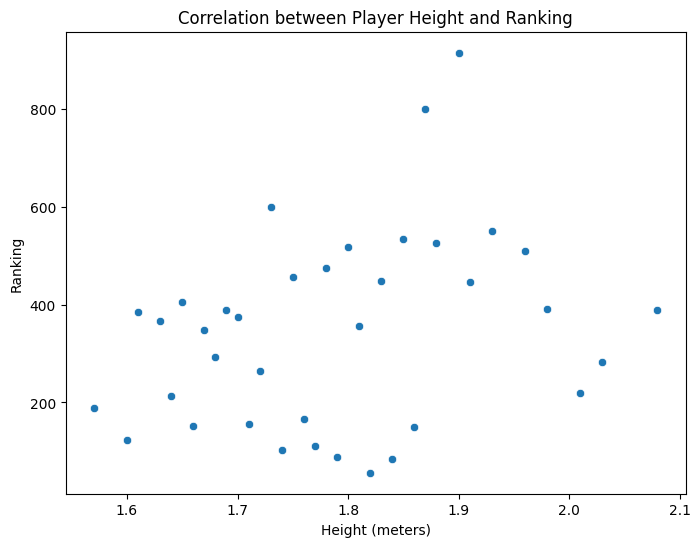

In [35]:
players_concat_df = pd.concat([match_away_team_df, match_home_team_df])
height_rank_correlation=players_concat_df['height'].corr(players_concat_df['current_rank'])

print("The correlation between height and ranking is: ", height_rank_correlation)

height_rank_mean = players_concat_df.groupby('height')['current_rank'].mean().reset_index()

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='height', y='current_rank', data=height_rank_mean)

plt.xlabel('Height (meters)')
plt.ylabel('Ranking')
plt.title('Correlation between Player Height and Ranking')
plt.show()

According to the scatter plot and height_rank_correlation value, it cannot be claimed that there is a correlation between players height and their rank.

11. What is the average duration of matches?

In [36]:
time_df=pd.read_csv('MatchTimeInfo.csv')
time_df.fillna(0,inplace=True)
total_duration = time_df['period_1'].sum() + time_df['period_2'].sum() + time_df['period_3'].sum()
num_matches = time_df['match_id'].nunique()

average_duration = total_duration / num_matches

print(f"The average duration of matches is {average_duration / 60:.2f} minutes.")

The average duration of matches is 182.77 minutes.


12. What is the average number of games per set in men's matches compared to women's matches?

In [37]:

power_player_id = pd.merge(power_df, players_id_concat, on='match_id')

total_games_per_set = power_player_id.groupby(['match_id', 'set_num', 'gender'])['game_num'].max()
total_games_per_set


match_id  set_num  gender
12260075  1        M         12
          2        M         10
12260076  1        M         12
          2        M          9
          3        M          9
                             ..
12384975  2        F         13
          3        F         10
12385017  1        F         10
          2        F         12
          3        F         12
Name: game_num, Length: 12736, dtype: int64

In [38]:
# Calculate the average games per set for each gender
gender_games_per_set = total_games_per_set.groupby('gender').mean()

print(f"The average number of games per set in men's matches is {gender_games_per_set['M']:.2f}.")
print(f"The average number of games per set in women's matches is {gender_games_per_set['F']:.2f}.")

The average number of games per set in men's matches is 9.28.
The average number of games per set in women's matches is 9.00.


On average, in men's matches, each set has 18 games and in women's matches, each set has 17 games

13. What is the distribution of left-handed versus right-handed players?

The distribution of right-handed players versus left-handed: plays
right-handed    11654
left-handed      1612
ambidextrous        8
Name: count, dtype: int64
The distribution of right-handed players versus left-handed: plays
right-handed    87.795691
left-handed     12.144041
ambidextrous     0.060268
Name: count, dtype: float64


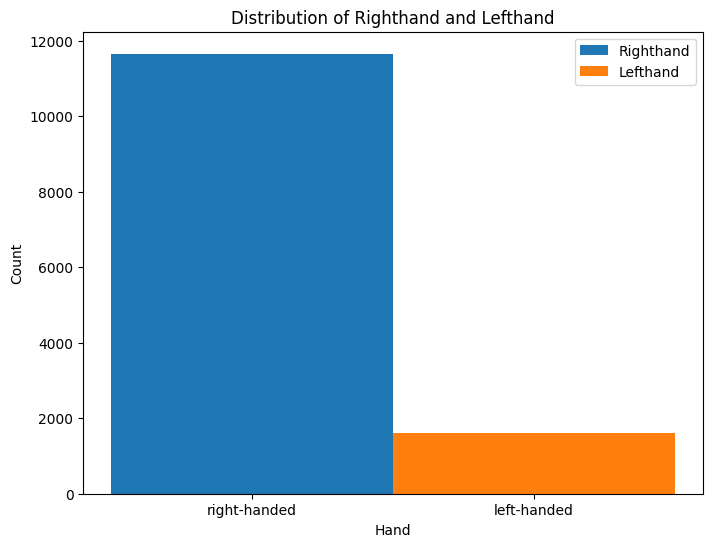

In [54]:

match_away_cleand_df = match_away_team_df.loc[match_away_team_df['plays'].notnull()]

match_home_cleand_df = match_home_team_df.loc[match_home_team_df['plays'].notnull()]


match_home_away_cleaned_df = pd.concat([match_away_cleand_df, match_home_cleand_df])
distribution = match_home_away_cleaned_df['plays'].value_counts()

print("The distribution of right-handed players versus left-handed:",distribution)

percentage_distribution = (distribution / len(match_home_away_cleaned_df)) * 100
print("The distribution of right-handed players versus left-handed:",percentage_distribution)

# Draw a histogram to view the distribution
righthand_data = match_home_away_cleaned_df.loc[match_home_away_cleaned_df['plays'] == 'right-handed']
lefthand_data = match_home_away_cleaned_df.loc[match_home_away_cleaned_df['plays'] == 'left-handed']

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(righthand_data['plays'], bins=1, label='Righthand')
ax.hist(lefthand_data['plays'], bins=1, label='Lefthand')

ax.set_xlabel('Hand')
ax.set_ylabel('Count')
ax.set_title('Distribution of Righthand and Lefthand')

ax.legend()
plt.show()

14. What is the most common type of surface used in tournaments?

ground_type
Red clay             14238
Hardcourt outdoor     4606
Hardcourt indoor       241
Synthetic outdoor       93
Name: count, dtype: int64


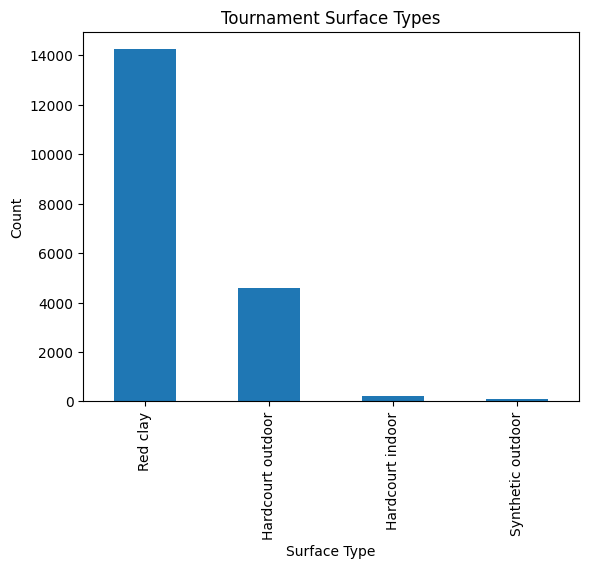

In [40]:

tournament_df.drop_duplicates(inplace=True)
print(tournament_df['ground_type'].value_counts())

# drow plot
tournament_df['ground_type'].value_counts().plot(kind='bar')
plt.title('Tournament Surface Types')
plt.xlabel('Surface Type')
plt.ylabel('Count')
plt.show()

The most common type of surface used in the tournaments is 'Red clay' that used in '14237' tournaments

15. How many distinct countries are represented in the dataset?

In [41]:
num_distinct_countries = match_home_away_cleaned_df['country'].nunique()

print(f"The dataset contains {num_distinct_countries} distinct countries.")

The dataset contains 78 distinct countries.


16. Which player has the highest winning percentage against top 10 ranked opponents?

In [42]:
country_current_rank=pd.concat([match_away_team_df[['name','current_rank']],match_home_team_df[['name','current_rank']]]).sort_values('current_rank').drop_duplicates().dropna().iloc[0:12,:]
top_10_players=country_current_rank['name'].unique()

In [43]:
game_info=pd.read_csv('GameInfo.csv')
point_count=game_info.iloc[:,[0,4,5]]
point_count.replace('A', pd.NA, inplace=True)
point_count['home_point'].fillna(0,inplace=True)
point_count['away_point'].fillna(0,inplace=True)
point_count['home_point'] = point_count['home_point'].astype(int)
point_count['away_point'] = point_count['away_point'].astype(int)

match_point_winner=point_count.groupby('match_id')[['home_point', 'away_point']].sum()
match_point_winner['winner_code'] = 0
match_point_winner.loc[match_point_winner['home_point'] > match_point_winner['away_point'], 'winner_code'] = 1
match_point_winner.loc[match_point_winner['home_point'] < match_point_winner['away_point'], 'winner_code'] = 2
match_winner=match_point_winner.iloc[:,[2]]

C:\Users\mahdi\AppData\Local\Temp\ipykernel_14612\3857551801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_count.replace('A', pd.NA, inplace=True)
C:\Users\mahdi\AppData\Local\Temp\ipykernel_14612\3857551801.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  point_count['home_point'].fillna(0,inplace=True)
C:\Users\mahdi\AppData\L

In [44]:
merged_df = pd.merge(match_home_team_df, match_away_team_df, on='match_id', how='inner', suffixes=('_player1', '_player2'))
merged_df=merged_df[['match_id','name_player1', 'name_player2']]
player_winner = pd.merge(merged_df,match_winner, on='match_id', how='inner')
player_winner.drop_duplicates(inplace=True)

player_winner['winner_name'] = player_winner.apply(lambda row: row['name_player1'] if row['winner_code'] == 1.0 else row['name_player2'], axis=1)
player_winner['loser_name'] = player_winner.apply(lambda row: row['name_player1'] if row['winner_code'] == 2.0 else row['name_player2'], axis=1)
player_winner_loser=player_winner.iloc[:,[0,4,5]]
player_winner_loser

,match_id,winner_name,loser_name
0,12260075,Lehečka J.,Lehečka J.
1,12260076,Khachanov K.,Khachanov K.
2,12260077,Alcaraz C.,Alcaraz C.
3,12260078,Alcaraz C.,Alcaraz C.
5,12260080,Zverev A.,Zverev A.
...,...,...,...
27541,12384789,Léonard M.,Léonard M.
27542,12384806,Dutra da Silva D.,Dutra da Silva D.
27543,12384892,Gomez F.,Gomez F.
27544,12384975,Șerban R.,Șerban R.


In [45]:
# Find the player with the highest winning percentage
top_10_matches =player_winner_loser[(player_winner_loser['loser_name'].isin(top_10_players))]
top_10_matches_winner=top_10_matches.iloc[:,[0,1]]

winner_counts = top_10_matches_winner['winner_name'].value_counts()
winner_percentages = (winner_counts / len(top_10_matches_winner)) * 100

player_with_highest_win = winner_percentages.idxmax()
highest_win_pct = winner_percentages.max()

print(f"The player with the highest winning percentage against top 10 ranked opponents is {player_with_highest_win}  ,with {highest_win_pct} percent win")
winner_counts


The player with the highest winning percentage against top 10 ranked opponents is Sabalenka A.  ,with 23.52941176470588 percent win


winner_name
Sabalenka A.      12
Ruud C.            7
Alcaraz C.         5
Medvedev D.        5
Rybakina E.        4
Rublev A.          4
Zheng Q.           4
Vondroušová M.     4
Sinner J.          3
Zverev A.          2
Gauff C.           1
Name: count, dtype: int64

17. What is the average number of breaks of serve per match? 
We use the dfPower dataframe(for PowerInfo table) previously read in question number 5.

In [46]:
total_breaks = power_df['break_occurred'].sum()

num_matches = power_df['match_id'].nunique()

average_breaks_per_match = total_breaks / num_matches
print(f"the average is: ",average_breaks_per_match )

the average is:  20.28867527786122


EXTRA QUESTION 1- Is there a correlation between a player's experience and their ranking?

In [47]:
match_home_team_turned_rank_df=match_home_team_df.iloc[:,[17,10,14]]
match_away_team_turned_rank_df=match_away_team_df.iloc[:,[17,10,14]]
turned_rank_player=pd.concat([match_home_team_turned_rank_df,match_away_team_turned_rank_df])
turned_rank_player.drop_duplicates()
turned_rank_player.dropna(inplace=True)
turned_rank_player['experience'] = 2024-turned_rank_player['turned_pro']
turned_rank_player.drop(columns='turned_pro', inplace=True)
turned_rank_player.drop_duplicates(inplace=True)
turned_rank_player.sort_values('current_rank')

,full_name,current_rank,experience
10708,"Sinner, Jannik",2.0,6.0
8,"Sabalenka, Aryna",2.0,9.0
2,"Alcaraz, Carlos",3.0,6.0
6689,"Gauff, Cori",3.0,6.0
4,"Zverev, Alexander",4.0,11.0
...,...,...,...
5879,"Gabashvili, Teimuraz",1272.0,23.0
4822,"Uzhylovsky, Vladimir",1341.0,19.0
42,"Clezar, Guilherme",1365.0,15.0
1354,"Gabashvili, Teimuraz",1452.0,23.0


In [48]:
experience_rank_correlation=turned_rank_player['experience'].corr(turned_rank_player['current_rank'])
if experience_rank_correlation <0.3:
    print('There is a weak correlation between players experience and there rank')
elif 0.3<experience_rank_correlation<0.5:
    print('There is a moderate correlation between players experience and there rank')
else:
    print('There is a strong correlation between players experience and there rank')

There is a weak correlation between players experience and there rank


EXTRA QUESTION 2- Is there a correlation between being right or left_hand and number of ranking?

In [49]:
handedness_ranking = players_id_concat.groupby('plays')['current_rank'].mean()

print(f"Right-handed players have an average ranking of {handedness_ranking['right-handed']:.2f}.")
print(f"Left-handed players have an average ranking of {handedness_ranking['left-handed']:.2f}.")

Right-handed players have an average ranking of 363.96.
Left-handed players have an average ranking of 386.66.


The results shows that being a right-handed player leads to have a better rank.

extra question no3.
Which 3_players who received the most prize money in tennis tournaments? 


In [50]:
country_total_prize=pd.concat([match_away_team_df[['full_name','total_prize']],match_home_team_df[['full_name','total_prize']]]).drop_duplicates()
country_total_prize.groupby('full_name').sum().sort_values('total_prize',ascending=False).iloc[0:3,:]

,total_prize
full_name,
"Nadal, Rafael",224653134.0
"Murray, Andy",107560350.0
"Medvedev, Daniil",67813632.0


EXTRA QUESTION 4 :How does the average number of winners per match differ between hard and clay court surfaces?

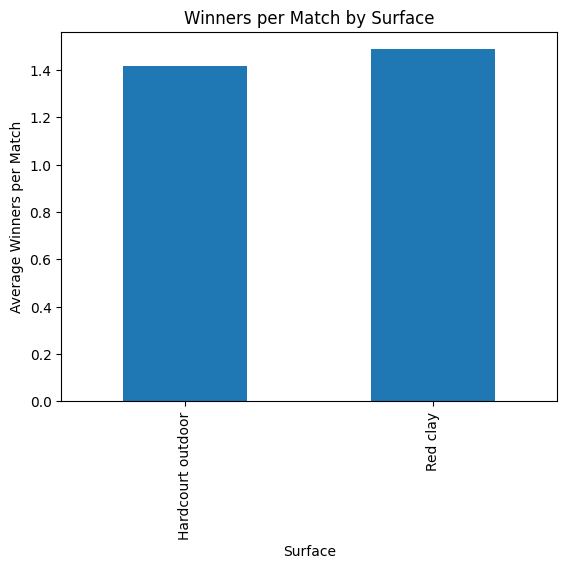

In [51]:
# Join the df_event and df_period DataFrames on 'match_id'
df_combined = pd.merge(event_df, tournament_df, on='match_id')

# Calculate the average winners per match for each surface
surface_winners = df_combined.groupby('ground_type')['winner_code'].mean()

# Plot the average winners per match for each surface
surface_winners.plot(kind='bar')
plt.xlabel('Surface')
plt.ylabel('Average Winners per Match')
plt.title('Winners per Match by Surface')
plt.show()


EXTRA QUESTION 5 : What is the number of winning matches for each player?

In [52]:
winner_counts = playerWinner['winner_name'].value_counts()
winner_counts





winner_name
Monteiro T.     118
Arnaboldi F.    103
Bertola R.      100
Shang J.         99
Melzer G.        99
               ... 
Rouvroy M.        1
Vukić A.          1
Cerundolo J.      1
Björklund M.      1
Krueger M.        1
Name: count, Length: 366, dtype: int64

For example Melzer G. won 118 times in matches.

In [53]:
20- 

SyntaxError: invalid syntax (2147078742.py, line 1)